# Prepare datas

In [1]:
!nvidia-smi

Sat Feb 29 19:20:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
from pycocotools.coco import COCO, maskUtils
import os


image_info = []

def add_image_info(image_id, image_path, **kwargs):
    im_info = {
        "image_id" : image_id,
        "image_path" : image_path,
        }
    im_info.update(kwargs)
    image_info.append(im_info)

root_path = "./drive/My Drive/darknet"
dataset_path = root_path + '/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

anns = dataset['annotations']
imgs = dataset['images']
img_ids = dict()

# Get id for image from path 
for img in imgs:
    img_ids[img['file_name']] = img['id']

coco = COCO(anns_file_path)
image_ids = coco.getImgIds()
class_ids = sorted(coco.getCatIds())

for i in image_ids:
    im = coco.imgs[i]
    add_image_info(image_id=i,
                   image_path=os.path.join(dataset_path, im['file_name']), 
                   width=im["width"],
                   height=im["height"],
                   annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))


loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


# Load mask

[{'id': 2, 'image_id': 1, 'category_id': 18, 'segmentation': [[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0, 990.0, 1808.0, 998.0, 1790.0, 1069.0, 1727.0, 1096.0, 1702.0, 1159.0, 1644.0, 1212.0, 1588.0, 1258.0, 1540.0, 1314.0, 1482.0, 1357.0, 1444.0, 1392.0, 1416.0, 1409.0, 1393.0, 1430.0, 1369.0, 1415.0, 1347.0, 1130.0, 1087.0, 780.0, 763.0, 528.0, 533.0, 479.0, 486.0, 466.0, 466.0, 448.0, 457.0, 427.0, 468.0, 387.0, 502.0, 321.0, 554.0, 244.0, 608.0, 118.0, 693.0, 37.0, 750.0, 3.0, 780.0, 1.0, 995.0, 28.0, 1032.0, 104.0, 1119.0, 403.0, 1471.0, 666.0, 1805.0, 763.0, 1954.0, 782.0, 1945.0, 796.0, 1970.0, 803.0, 1976.0, 818.0, 1976.0, 836.0, 1956.0, 852.0, 1954.0, 860.0, 1937.0, 873.0, 1931.0, 885.0, 1908.0, 898.0, 1896.0, 928.0, 1876.0]], 'area': 1071259.5, 'bbox': [1.0, 457.0, 1429.0, 1519.0], 'iscrowd': 0}, {'id': 3, 'image_id': 1, 'category_id': 14, 'segmentation': [[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 725.0, 459.0, 747.0, 482.0, 760.0, 483.0, 780.0, 506.0, 794.0, 520.0, 807.0,

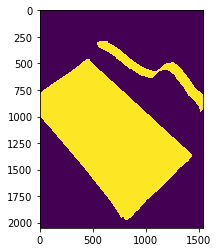

./drive/My Drive/darknet/data/batch_1/000008.jpg


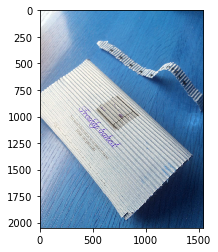

In [0]:
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["Blur", "AWGN", "Add","Multiply"]:
        return False
    else:
        # default value for all other augmenters
        return default

def apply_mask(image, mask):
    seg_mask = mask.sum(axis=2).astype(np.bool8)
    mask_image = []
    for j in range(3):
        mask_image.append(np.multiply(image[:, :, j], seg_mask))
    mask_image = np.stack(np.array(mask_image), axis=2)
    return mask_image

def ann_to_mask(ann, height, width):
    segm = ann['segmentation']
    if isinstance(segm, list):
        # encode the mask into a single run-length encoded mask
        mask_encodings = maskUtils.frPyObjects(segm, height, width)
        mask_encoding = maskUtils.merge(mask_encodings)
    else:
        # already encoded
        mask_encoding = segm
    mask = maskUtils.decode(mask_encoding)
    return mask


def load_mask(image_id):
    """Load instance masks for the given image.

    Different datasets use different ways to store masks. This
    function converts the different mask format to one format
    in the form of a bitmap [height, width, instances].

    Returns:
    masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
    class_ids: a 1D array of class IDs of the instance masks.
    """

    im_info = image_info[image_id]
    # print(im_info)
    instance_masks = []
    class_ids = []
    annotations = im_info["annotations"]
    print(annotations)
    # print(json.dumps(annotations, indent=2))
    # Build mask of shape [height, width, instance_count] and list
    # of class IDs that correspond to each channel of the mask.
    for annotation in annotations:
        class_id = annotation["category_id"]
        if class_id:
            m = ann_to_mask(annotation, im_info["height"],
                            im_info["width"])
            # Some objects are so small that they're less than 1 pixel area
            # and end up rounded out. Skip those objects.
            if m.max() < 1:
                continue
            instance_masks.append(m)
            class_ids.append(class_id)

    # Pack instance masks into an array
    if len(class_ids) != 0:            
        mask = np.stack(instance_masks, axis=2).astype(np.bool)            
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids

def load_image(image_id):
    """Load the specified image and return as a [H,W,3] Numpy array."""

    image = cv.imread(image_info[image_id]['image_path'])    
    img_shape = np.shape(image)

    # If has an alpha channel, remove it for consistency
    if img_shape[-1] == 4:
        image = image[..., :3]
    return np.array(image)

import matplotlib.pyplot as plt    

mask, _ = load_mask(1)
mask_total = np.sum(mask, axis=2)
plt.imshow(mask_total)
plt.show()
import cv2 as cv
print(image_info[1]["image_path"])
image = cv.imread(image_info[1]["image_path"])
plt.imshow(image)
plt.show()
# np.stack(np.array([np.arange(0, 20, 1)]), axis=1)

# Data augumentation

[{'id': 2635, 'image_id': 853, 'category_id': 5, 'segmentation': [[1064.0, 1540.0, 1071.0, 1530.0, 1082.0, 1525.0, 1095.0, 1518.0, 1101.0, 1514.0, 1110.0, 1511.0, 1119.0, 1508.0, 1124.0, 1507.0, 1126.0, 1504.0, 1135.0, 1504.0, 1143.0, 1496.0, 1151.0, 1489.0, 1160.0, 1486.0, 1194.0, 1469.0, 1198.0, 1465.0, 1204.0, 1463.0, 1213.0, 1461.0, 1221.0, 1462.0, 1229.0, 1459.0, 1235.0, 1459.0, 1241.0, 1460.0, 1254.0, 1455.0, 1261.0, 1462.0, 1265.0, 1468.0, 1267.0, 1474.0, 1269.0, 1480.0, 1267.0, 1484.0, 1255.0, 1491.0, 1251.0, 1491.0, 1249.0, 1496.0, 1246.0, 1503.0, 1243.0, 1510.0, 1238.0, 1517.0, 1233.0, 1522.0, 1226.0, 1526.0, 1219.0, 1532.0, 1207.0, 1534.0, 1199.0, 1533.0, 1189.0, 1538.0, 1180.0, 1546.0, 1175.0, 1546.0, 1174.0, 1555.0, 1160.0, 1559.0, 1154.0, 1555.0, 1145.0, 1565.0, 1136.0, 1567.0, 1077.0, 1569.0, 1072.0, 1568.0, 1071.0, 1565.0, 1067.0, 1561.0, 1066.0, 1553.0, 1063.0, 1548.0, 1064.0, 1540.0]], 'area': 11730.0, 'bbox': [1063.0, 1455.0, 206.0, 114.0], 'iscrowd': 0}, {'id': 2636

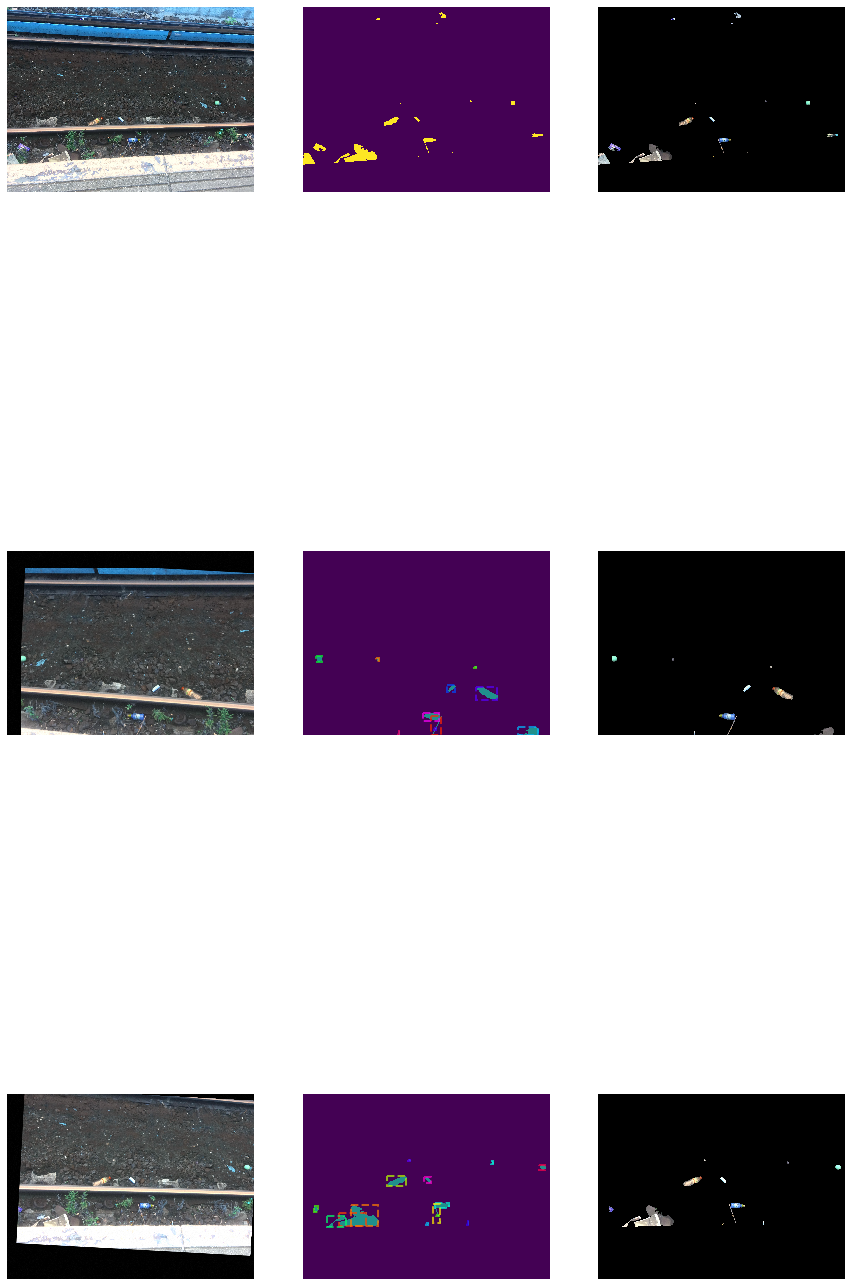

In [0]:
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
from matplotlib.patches import Polygon, Rectangle
import colorsys
import random
import cv2


nr_augmentations = 2

image_id = np.random.choice(len(image_ids))

# image_id = np.random.choice(1)
image = load_image(image_id)
mask, _  = load_mask(image_id)
annotations = image_info[image_id]["annotations"]
print(image_info[image_id])
# Augumentation pipeline
seq = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="AWGN"),
        iaa.GaussianBlur(sigma=(0.0, 3.0), name="Blur"),
        # iaa.Dropout([0.0, 0.05], name='Dropout'), # drop 0-5% of all pixels
        iaa.Fliplr(0.5),
        iaa.Add((-20, 20),name="Add"),
        iaa.Multiply((0.8, 1.2), name="Multiply"),
        iaa.Affine(scale=(0.8, 2.0)),
        iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
        iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees
    ], random_order=True)
    
hooks_masks = ia.HooksImages(activator=activator_masks)

def create_bbox(mask):    
    img = mask.astype(np.int8)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    w = xmax - xmin
    h = ymax - ymin    
    return xmin, ymin, w, h

# Initialize the matplotlib figure
fig, aux = plt.subplots(ncols=3, nrows=nr_augmentations+1, figsize=(15,30))

aux[0,0].imshow(image)
aux[0,0].axis('off')


aux[0,1].imshow(mask.sum(axis=2).astype(np.bool8))
aux[0,1].axis('off')

aux[0,2].imshow(apply_mask(image, mask))
aux[0,2].axis('off')

print('This may take some time, as we are working with the original image size...')

def augumented_images(image, mask, nr_augmentations):
    for i in range(nr_augmentations):
        seq_det = seq.to_deterministic()
        image_augmented = seq_det.augment_image(image)
        mask_augmented = seq_det.augment_image(mask.astype(np.uint8), hooks=hooks_masks)
        seq_mask = np.sum(mask_augmented, axis=2)

        for num_mask in range(mask_augmented.shape[2]):
            if(np.any(mask_augmented[:,:,num_mask])):
                x, y, w, h = create_bbox(mask_augmented[:,:,num_mask])
                # if mask is out of image
                if x + w < image_augmented.shape[1] and y + h < image_augmented.shape[0]: 
                    rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=colorsys.hsv_to_rgb(np.random.random(),1,1),
                                        facecolor='none', alpha=0.7, linestyle = '--')
                    aux[i+1,1].add_patch(rect)
                    #compute relative coordonates for bbox
                    print(annotations[num_mask]['category_id'])
                    width = image_augmented.shape[1]
                    height = image_augmented.shape[0]
                    x_center = (x + w / 2) / width
                    y_center = (y + h / 2) / height
                    width = w / width
                    height = h / height

        # cv2.imwrite("drive/My Drive/augm/image" + str(i) + ".jpg", image_augmented)
        #TODO:write to train file
        # compute relative and class labels

        # uncommnet for plot
        aux[i+1,0].imshow(image_augmented)
        aux[i+1,0].axis('off')

        aux[i+1,1].imshow(seq_mask)    
        aux[i+1,1].axis('off')

        aux[i+1,2].imshow(apply_mask(image_augmented, mask_augmented))
        aux[i+1,2].axis('off')

# Augment images and masks

augumented_images(image, mask, nr_augmentations)

# create_bbox(mask)
plt.subplots_adjust(wspace=0.2, hspace=0)

# Save data

In [0]:

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

root_path = "./drive/My Drive/darknet"
dataset_path = root_path + '/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_last_name = categories[0]['supercategory']
super_cat_ids = {super_cat_last_name: 0}
nr_super_cats = 1
cat_to_super_cat = {}

img_ids = dict()
# Get id for image from path 
for img in imgs:
    img_ids[img['file_name']] = img['id']



for i, cat_it in enumerate(categories):
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # print("Index: {}, cat: {}, supercat: {}".format(i, cat_it['name'], cat_it['supercategory']))
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1
    cat_to_super_cat[i] = nr_super_cats - 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)
# print('Super category names: ' + str(super_cat_names))
print('Super category names: ' + str(super_cat_ids))
print('Cat to super cat: ' + str(cat_to_super_cat))

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500
Super category names: {'Aluminium foil': 0, 'Battery': 1, 'Blister pack': 2, 'Bottle': 3, 'Bottle cap': 4, 'Broken glass': 5, 'Can': 6, 'Carton': 7, 'Cup': 8, 'Food waste': 9, 'Glass jar': 10, 'Lid': 11, 'Other plastic': 12, 'Paper': 13, 'Paper bag': 14, 'Plastic bag & wrapper': 15, 'Plastic container': 16, 'Plastic glooves': 17, 'Plastic utensils': 18, 'Pop tab': 19, 'Rope & strings': 20, 'Scrap metal': 21, 'Shoe': 22, 'Squeezable tube': 23, 'Straw': 24, 'Styrofoam piece': 25, 'Unlabeled litter': 26, 'Cigarette': 27}
Cat to super cat: {0: 0, 1: 1, 2: 2, 3: 2, 4: 3, 5: 3, 6: 3, 7: 4, 8: 4, 9: 5, 10: 6, 11: 6, 12: 6, 13: 7, 14: 7, 15: 7, 16: 7, 17: 7, 18: 7, 19: 7, 20: 8, 21: 8, 22: 8, 23: 8, 24: 8, 25: 9, 26: 10, 27: 11, 28: 11, 29: 12, 30: 13, 31: 13, 32: 13, 33: 13, 34: 14, 35: 14, 36: 15, 37: 15, 38: 15, 39: 15, 40: 15, 41: 15, 42: 15, 43: 16, 44: 16, 45: 16, 46: 16, 47: 16, 48